<h1>Importing Libraries</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import re

In [3]:
import pandas as pd

In [4]:
train=pd.read_excel("Train.xlsx")
test=pd.read_excel("Test.xlsx")

<h1>EDA</h1>

In [5]:
train.drop(['S.No'],axis=1,inplace=True)
test.drop(['S.No'],axis=1,inplace=True)

In [6]:
train['screen_name'].nunique()

2843

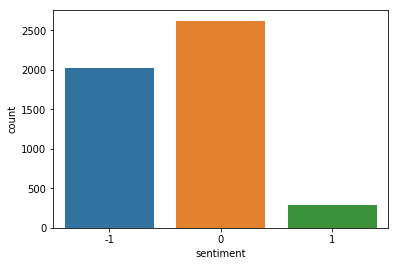

In [7]:
sns.countplot(train['sentiment'])

In [8]:
train['name'].nunique()

2777

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [10]:
train.isnull().sum()

id                            0
created_at                    0
favorited                     0
text                          0
screen_name                   0
name                          0
friends_count                 0
followers_count               0
statuses_count                0
verified                      0
in_reply_to_screen_name    1174
sentiment                     0
dtype: int64

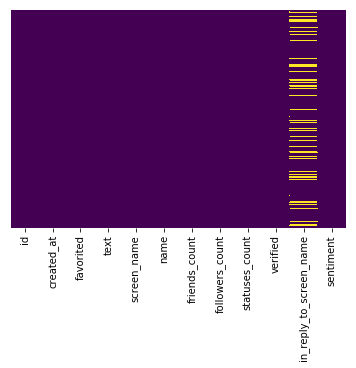

In [11]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
train.drop(['created_at'],inplace=True,axis=1)

In [13]:
test.drop(['created_at'],inplace=True,axis=1)

In [14]:
train.shape

(4935, 11)

In [15]:
test.shape

(2116, 10)

In [16]:
train.head()

,id,favorited,text,screen_name,name,friends_count,followers_count,statuses_count,verified,in_reply_to_screen_name,sentiment
0,909,0,It's been 2 days and my #AirtelDTH issue is st...,RajanMNaidu,Rajan Naidu,103,905,17061,0,NaN,0
1,909,0,@Airtel_Presence Hello 2rs network @airtelindi...,TheDesiBoyy,Sunny,120,75,506,0,Airtel_Presence,0
2,909,0,what I can see Airtel TV app streams way bette...,MarwadiTweeter,<U+092E><U+093E><U+0930><U+0935><U+093E><U+095...,593,724,52909,0,NaN,0
3,909,0,@Airtel_Presence Sorry I have registered on Ur...,Karthikblues,Karthik Vijay,367,171,219,0,Airtel_Presence,-1
4,908,0,Porting out of @RelianceMobile\nWhat is best o...,Ankishj,Ankish,142,58,257,0,NaN,0


We removed these <ed>,<U+00A0>, <U+00BD>,<U+00A1>,<U+00BD>, <U+20B9>,<U+0080>,<U+00BD>,<U+0082>,<U+00BE>,<U+00A3> manually through excel.

<h2>Removing Twitter Handles @user</h2>

In [17]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [18]:
sentiment=train['sentiment']

In [19]:
train.shape

(4935, 11)

In [20]:
test.shape

(2116, 10)

In [21]:
train.drop(['sentiment'],axis=1,inplace=True)

In [22]:
combi = train.append(test, ignore_index=True)

In [23]:
combi.shape

(7051, 10)

In [24]:
combi.drop(['name','screen_name','in_reply_to_screen_name'],axis=1,inplace=True)

In [25]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

Removing punctuations,numbers and special characters

In [26]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

Removing Short Words

In [27]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Tokenization

In [28]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

Stemming

In [29]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [30]:
#Bring these back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

<h2>Word Cloud of Common Information</h2>

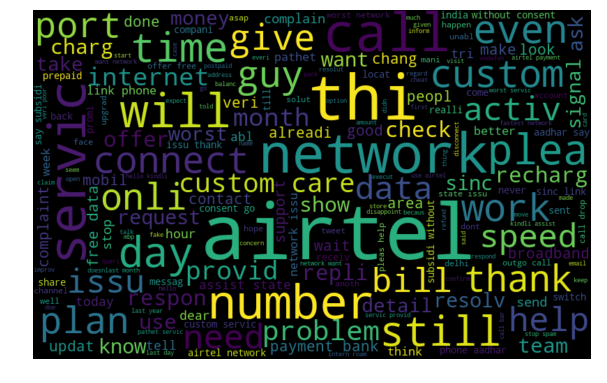

In [31]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<h2>Bag Of Words</h2>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer( min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

<h2>Modeling Using Bag Of Words (Random Forest)</h2>

In [33]:
train.shape

(4935, 10)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score

In [35]:
train_bow = bow[:4935,:]
test_bow = bow[4935:,:]

In [36]:
twenty= list(train_bow.toarray())
twenty1=pd.DataFrame(twenty)

In [37]:
final_tr=combi.iloc[:4935,:]

In [38]:
final_tr.drop(['text','tidy_tweet'],axis=1,inplace=True)

/home/nephalem/miniconda3/envs/AI/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
final_tr=pd.concat([final_tr,twenty1],axis=1)

In [40]:
twenty2= list(test_bow.toarray())
twenty3=pd.DataFrame(twenty)

In [41]:
final_test=combi.iloc[4935:,:]

In [42]:
final_test.drop(['text','tidy_tweet'],axis=1,inplace=True)

In [43]:
final_test=pd.concat([final_test,twenty3],axis=1)

In [44]:
X=train_bow
y=sentiment
test=test_bow

In [45]:
rfc=RandomForestClassifier(n_estimators=800)

In [46]:
y.shape

(4935,)

In [47]:
X.shape

(4935, 1000)

In [48]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
pred_rfc=rfc.predict(test)

In [50]:
pred_rfc

array([ 0,  0,  0, ..., -1,  0,  0])

In [51]:
predictions=pd.DataFrame()

In [52]:
SerialNo=pd.read_excel("Test.xlsx")

###### predictions['S.No']=SerialNo['S.No']
predictions['sentiment']=pred_rfc

In [ ]:
predictions['sentiment'].value_counts()

In [ ]:
predictions.to_csv('Try.csv')

<h2>Modeling Using StackNEt</h2>

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models=[ 
            ######## First level ########
            [RandomForestClassifier (n_estimators=200, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
             ExtraTreesClassifier (n_estimators=200, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
             GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, max_features=0.5, random_state=1),
             LogisticRegression(random_state=1)
             ],
            ######## Second level ########
            [RandomForestClassifier (n_estimators=400, criterion="entropy", max_depth=5, max_features=0.5, random_state=1)]
            ]

In [ ]:
from pystacknet.pystacknet import StackNetClassifier

In [ ]:
model=StackNetClassifier(models, folds=3,
	restacking=False,use_retraining=True, use_proba=True,n_jobs=1, verbose=1)

In [ ]:
model.fit(X,y)

In [ ]:
preds=model.predict_proba(test)

In [ ]:
preds

In [ ]:
SerialNo=pd.read_excel("Test.xlsx")

In [ ]:
import pandas as pd
pds=pd.DataFrame()
pds['S.No']=SerialNo['S.No']

In [ ]:
pds['sentiment']=preds

In [ ]:
preds.to_csv("StackNet.csv")

In [55]:
y_true=pd.read_excel("TrueSubmission.xlsx")

In [58]:
y_true1=y_true['sentiment']

<h2>Classification Report</h2>

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_true1,pred_rfc))

              precision    recall  f1-score   support

          -1       0.66      0.62      0.64       873
           0       0.69      0.75      0.72      1099
           1       0.75      0.51      0.61       144

   micro avg       0.68      0.68      0.68      2116
   macro avg       0.70      0.63      0.65      2116
weighted avg       0.68      0.68      0.68      2116



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(y_true1,pred_rfc))